In [10]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from itertools import permutations 
import sys
base = '/home3/ebrahim/isr/'
sys.path.append(base)
from model import RNN_feedback
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from scipy.stats import pearsonr
import pandas as pd
import seaborn as sns
import pickle


In [11]:
class Regression_Trials(Dataset):

    def __init__(self, num_letters, letters_subset, list_length):

        '''
        Dataset is composed of all possible permutations of 
        the available subset of letters (s) for the specified list length (l).

        Example: If a,b, and c are the available letters, and list length is 2,
        then the dataset will be {ab, ba, ac, ca, bc, cb}.

        Length of this dataset is s! / (s-l)!. 

        @param num_letters: number of total letters (classes - 1) RNN was trained on
        @param letters_subset: subset of letters used for regression analyses 
        @param list_length: length of list for regression analyses 
        '''
        X_p = [] # store permutations 
        X_int = permutations(letters_subset, list_length)

        for p in X_int:
            X_p.append(p)

        X_int = np.stack(X_p) # shape: num_permutations x list_length 
        
        recall_cue = np.ones((X_int.shape[0], list_length+1)) * num_letters 
        self.X = torch.nn.functional.one_hot(torch.from_numpy(np.hstack((X_int, recall_cue))).to(torch.long)
        , num_classes=num_letters+1)

        end_of_list_cue = np.ones((X_int.shape[0], 1)) * num_letters
        y_int = torch.from_numpy(np.hstack((X_int, X_int, end_of_list_cue))).to(torch.long)
        self.y = torch.nn.functional.one_hot(y_int, num_classes=num_letters+1)

        self.X_reg = np.hstack((X_int, X_int)).T

    def __len__(self):

        return self.X.size(0)

    def __getitem__(self, idx):

        return self.X[idx].to(torch.float32), self.y[idx].to(torch.float32)

In [17]:
def inverse_sigmoid(y):

    '''
    Reverses impact of sigmoid
    '''
    return torch.log(y/(1-y))

def regression_RNN_activity(model, dataloader, batch_size):

    model.eval()

    hidden_arr = []

    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            x, r, y_hat = model.init_states(batch_size, device)

            for timestep in range(X.shape[1]-1):
                y_hat, x, r = model(X[:, timestep, :], x, r, y_hat)
                hidden_arr.append(inverse_sigmoid(r))
            
    return torch.stack(hidden_arr)


In [13]:
letters_subset = [0,1,4,7,10,13,16,19,22,25]
list_length = 4
rt = Regression_Trials(26, letters_subset, list_length)
rt_dataloader = DataLoader(rt, batch_size=len(rt), shuffle=False)

In [15]:
device = torch.device("cuda:0")

# load model
base = '/home3/ebrahim/isr/'
path = base + 'saved_models/simulation_one_weights/run_2/'
with open(path + 'model_settings.pkl', 'rb') as handle:
    ms = pickle.load(handle)
model = RNN_feedback(ms['is'], ms['hs'], ms['os'], ms['init_wrec'], ms['alpha_s'], ms['alpha_r'], 'sigmoid')
model.load_state_dict(torch.load(path + 'final_model_weights.pth'))
model.to(device)

# obtain h2o weights
for name, param in model.named_parameters():
    if name == 'h2o.weight':
        h2o_weight = param.detach().cpu().numpy()
h2o_weight_subset = h2o_weight[letters_subset]

In [18]:
hidden_activity = regression_RNN_activity(model, rt_dataloader, len(rt))
hidden_activity = hidden_activity.cpu().numpy()

In [19]:
X = rt.X[:, 0:8, :-1].cpu().numpy().argmax(2)
print(X.shape)
print(hidden_activity.shape)

(5040, 8)
(8, 5040, 200)


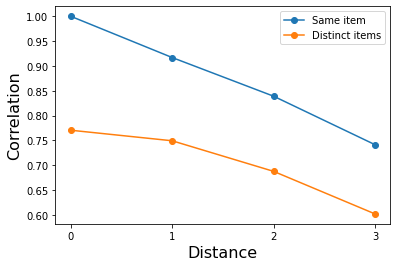

In [22]:
def positional_similarity_simple(t1, t2):

    # obtain input and hidden activity at time t1 and t2
    Xt1 = X[:, t1]
    Xt2 = X[:, t2]
    ht1 = hidden_activity[t1]
    ht2 = hidden_activity[t2]

    # list of length number of unique letters in X
    # for every unique letter, stores the model representations at 
    # respective times 
    item_representations_t1 = []
    item_representations_t2 = []

    # Step 1) Obtain model representation for each item at t1 and t2
    for x in np.unique(X):

        # locate all instances where a given letter occurs at t1 and t2
        x_location_t1 = np.argwhere(Xt1 == x)
        x_location_t2 = np.argwhere(Xt2 == x)

        # append or average across these representations 
        item_representations_t1.append(np.ravel(ht1[x_location_t1]))
        item_representations_t2.append(np.ravel(ht2[x_location_t2]))

    corr_same = []
    corr_diff = []

    # Step 2) Compute similarity between item representations 
    for i, ht1 in enumerate(item_representations_t1):
        for j, ht2 in enumerate(item_representations_t2):
            if i == j:
                r_same, _ = pearsonr(ht1, ht2)
                corr_same.append(r_same)
            else:
                r_diff, _ = pearsonr(ht1, ht2)
                corr_diff.append(r_diff)

    return corr_same, corr_diff

corr_same_avg = []
corr_diff_avg = []
for i in range(4):
    corr_same, corr_diff = positional_similarity_simple(0,i)
    corr_same_avg.append(np.mean(corr_same))
    corr_diff_avg.append(np.mean(corr_diff))


plt.plot(np.arange(4), corr_same_avg, marker='o', label='Same item')
plt.plot(np.arange(4), corr_diff_avg, marker='o', label='Distinct items')
plt.xlabel("Distance", fontsize=16)
plt.ylabel("Correlation", fontsize=16)
plt.xticks([0, 1, 2, 3])
plt.legend()
plt.show()


In [10]:
# convert to one hot encoding 
X_reg = rt.X_reg
enc = OneHotEncoder(sparse=False)
X_transform = enc.fit_transform(X_reg.T)

In [128]:
# There should be 40 element vectors at time 1
# relating how each letter at time 1 relates to the hidden activity
# that means that X needs to be of shape __ x 40 
# so that the weights are 40 x 200

# right now we have 5040 lists of length 10 at time 1 
# so previously our weight matrix was 10 x 200 
# an element vector for each letter at time 1 

# next at time 2 we have a weight matrix of 20 x 200
# so one for each letter + for each position 



(5040, 200)


In [12]:
def compute_element_vectors(X_all, y_all, num_features, timestep, seed):

    '''
    @param X_all (numpy array): shape num_permutations x (num_features x num_timesteps)
    @param y_all (numpy array): shape num_timesteps x num_permutations x num
    @param num_features (int): number of features used to encode each letters
    @param timestep (int): timestep to predict y, given X from t = 0:timestep
    @param seed (int): seed used to initalize random number generator

    Ridge regression model is fit from selected portions of X to y[timestep],
    and columns of weights correspond to element vectors. 
    '''
    
    X = X_all[:, :num_features*timestep]
    y = y_all[timestep-1]
    
    rng = np.random.default_rng(seed)
    train_ind = rng.choice(X_transform.shape[0], int(X.shape[0]*.8))
    test_ind = np.setdiff1d(np.arange(0,X.shape[0],1), train_ind) 

    reg = Ridge(alpha=.01).fit(X[train_ind], y[train_ind])
    y_hat = reg.predict(X[test_ind])

    r2_score_value = r2_score(y[test_ind], y_hat)

    return round(r2_score_value,5), reg.coef_

In [39]:
def partition_W(W, num_features, MA):
    for i in range(int(W.shape[1]/num_features)):
        MA[i].append(W[:, i*num_features:(i+1)*num_features])

In [63]:
MA = []
for t in [1,2,3,4,5,6,7,8]:
    MA.append([])
    r2_score_value, W = compute_element_vectors(X_transform, hidden_activity, len(letters_subset), t, 10)
    partition_W(W, len(letters_subset), MA)

In [68]:
MA_t = np.stack(MA[1])
print(MA_t.shape)

cosine_sim = np.zeros((MA_t.shape[0], MA_t.shape[2]))
for t in range(cosine_sim.shape[0]):
        for l in range(cosine_sim.shape[1]):
            cosine_sim[t,l] = np.dot(MA_t[t, :, l], h2o_weight_subset[l]
            ) / (np.linalg.norm(MA_t[t, :, l]) * np.linalg.norm(h2o_weight_subset[l]))

(7, 200, 10)


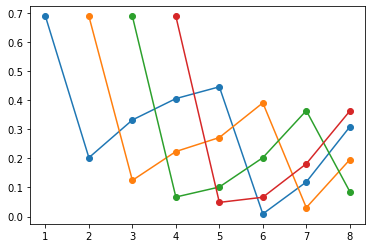

In [77]:
labels = ['1', '2', '3', '4']
for p in range(list_length):
    MA_t = np.stack(MA[p])
    cosine_sim = np.zeros((MA_t.shape[0], MA_t.shape[2]))
    for t in range(cosine_sim.shape[0]):
        for l in range(cosine_sim.shape[1]):
            cosine_sim[t,l] = np.dot(MA_t[t, :, l], h2o_weight_subset[l]
            ) / (np.linalg.norm(MA_t[t, :, l]) * np.linalg.norm(h2o_weight_subset[l]))

    plt.plot(np.arange(p+1,int(list_length*2)+1, 1), np.mean(cosine_sim, axis=1), marker='o', label=labels[p])

Text(0, 0.5, 'Cosine similarity')

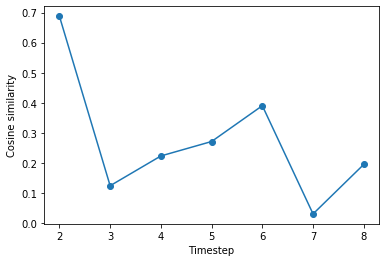

In [69]:
plt.plot(np.arange(2,9), np.mean(cosine_sim, axis=1), marker='o')
plt.xlabel('Timestep')
plt.ylabel('Cosine similarity')

Text(0.5, 1, 'Correlation between element vectors')

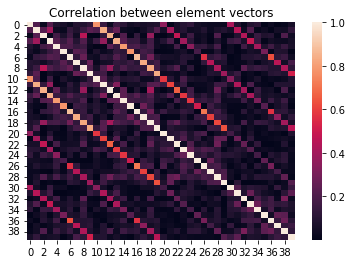

In [123]:
df = pd.DataFrame(W)
W_corr = df.corr(method='pearson')
sns.heatmap(np.abs(W_corr))
plt.title("Correlation between element vectors")

In [124]:
def figure_4_code(W_corr):

    c1 = []
    c2 = []
    c3 = []

    for i in range(10):
        c1.append(W_corr.iloc[i, i+10])
        c2.append(W_corr.iloc[i, i+2*10])
        c3.append(W_corr.iloc[i, i+3*10])

    c0_n = []
    c1_n = []
    c2_n = []
    c3_n = []
    for i in range(10):
        for j in range(10):
            if i == j:
                continue
            c0_n.append(W_corr.iloc[i,j])
            c1_n.append(W_corr.iloc[i,j+10])
            c2_n.append(W_corr.iloc[i,j+2*10])
            c3_n.append(W_corr.iloc[i,j+3*10])

    c_same_item = [c1, c2, c3]
    c_diff_item = [c0_n, c1_n, c2_n, c3_n]

    return c_same_item, c_diff_item

c_same, c_diff = figure_4_code(np.abs(W_corr))

In [125]:
np.stack(c_same).shape
np.stack(c_diff).shape

(4, 90)

In [126]:
for c in c_diff:
    print("MEAN: ", np.mean(c))
    print("STD: ", np.std(c))

MEAN:  0.14209696809400485
STD:  0.09759613690206982
MEAN:  0.11679504014246622
STD:  0.08335401235306147
MEAN:  0.06387526253347642
STD:  0.05096811324490779
MEAN:  0.0730614128854837
STD:  0.05534234988713269


In [ ]:
0